In [2]:
from __future__ import print_function

import os,sys,cv2,random,datetime,time,math
from collections import namedtuple
from tqdm import tqdm
import argparse
from operator import attrgetter

import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import torch
from torchvision import transforms as T
from torchvision.utils import save_image, make_grid
import torch.nn.functional as F
torch.backends.cudnn.bencmark = True

import net_s3fd
from bbox import *

In [3]:
Face = namedtuple('Face', ['fname', 'bbox', 'score'])
tensor2pil = T.ToPILImage()

In [55]:

detect_single_faces(args)

  0%|          | 0/3820 [00:00<?, ?it/s]

found 20241 images from /home/data/hairstyle/images


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]
100%|█████████▉| 3816/3820 [00:00<00:00, 17341.22it/s]


error: OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


In [53]:
def detect_single_faces(args):
    model = load_model(args)
    
    dname = args.dname
    dname_result = args.dname_result
    fnames = os.listdir(dname)
    fnames = [os.path.join(dname, fname) for fname in fnames]
    print('found {} images from {}'.format(len(fnames), dname))
    
    results, faces = detect_faces(fnames, model, args.pre_thresh)
    
    results_noface, results_oneface, results_multiple = split_results_by_num_faces(results)
    
    scores = [face.bbox[4] for face in faces]
    scores_oneface = [result.bbox[0, 4] for result in results_oneface]
    num_faces = [result.bbox.shape[0] for result in results]
    
    results_oneface_belowthresh = [result for result in results_oneface if result.bbox[0, 4] < args.thresh]
    results_oneface_valid = [result for result in results_oneface if result.bbox[0, 4] >= args.thresh]
    
    save_histogram(scores, os.path.join(dname_result, 'scores.png'))
    save_histogram(scores_oneface, os.path.join(dname_result, 'scores_oneface.png'))
    save_histogram_discrete(num_faces, os.path.join(dname_result, 'num_faces.jpg'))
    
    save_results(results_noface, os.path.join(dname_result, 'results_noface.jpg'))
    save_results(results_oneface_belowthresh, os.path.join(dname_result, 'results_oneface_belowthresh.jpg'))
    save_results(results_oneface_valid, os.path.join(dname_result, 'results_oneface_valid.jpg'))
    save_results(results_multiple, os.path.join(dname_result, 'results_multiple.jpg'))

In [41]:
def detect_faces(fnames, model, pre_thresh):
    results, faces = [], []
    for i, fname in enumerate(tqdm(fnames[:3820])):
        img = cv2.imread(fname)

        bboxlist = detect(model, img)

        keep = nms(bboxlist, 0.3)
        bboxlist = bboxlist[keep, :]
        keep = bboxlist[:, 4] > pre_thresh
        bboxlist = bboxlist[keep, :]

        results.append(Face(fname, bboxlist, None))
        for b in bboxlist:
            # x1, y1, x2, y2, s = b
            face = Face(fname, b, b[4])
            faces.append(face)
    return results, faces

In [29]:
@torch.no_grad()
def detect(net,img, resize=512):
    img = cv2.resize(img, (resize, resize))
    img = img - np.array([104,117,123])
    img = img.transpose(2, 0, 1)
    img = img.reshape((1,)+img.shape)

    img = torch.from_numpy(img).float().cuda()
    BB,CC,HH,WW = img.size()
    olist = net(img)

    bboxlist = []
    for i in range(len(olist)//2): olist[i*2] = F.softmax(olist[i*2])
    olist = [oelem.data.cpu() for oelem in olist]
    for i in range(len(olist)//2):
        ocls,oreg = olist[i*2],olist[i*2+1]
        FB,FC,FH,FW = ocls.size() # feature map size
        stride = 2**(i+2)    # 4,8,16,32,64,128
        anchor = stride*4
        poss = zip(*np.where(ocls[:,1,:,:]>0.05))
        for Iindex, hindex, windex in poss:
            axc,ayc = stride/2+windex*stride,stride/2+hindex*stride
            score = ocls[0,1,hindex,windex]
            loc = oreg[0,:,hindex,windex].contiguous().view(1,4)
            if score<0.05: continue
            priors = torch.Tensor([[axc/1.0,ayc/1.0,stride*4/1.0,stride*4/1.0]])
            variances = [0.1,0.2]
            box = decode(loc,priors,variances)
            x1,y1,x2,y2 = box[0]*1.0
            # cv2.rectangle(imgshow,(int(x1),int(y1)),(int(x2),int(y2)),(0,0,255),1)
            bboxlist.append([x1,y1,x2,y2,score])
    bboxlist = np.array(bboxlist)
    if 0==len(bboxlist): bboxlist=np.zeros((1, 5))
    return bboxlist

In [30]:
def save_histogram(data, fname, num_bins=10):
    fig = plt.figure()
    n, bins, patches = plt.hist(data, num_bins, facecolor='gray', alpha=0.5)
    fig.savefig(fname)


In [31]:
def save_histogram_discrete(data, fname):
    fig = plt.figure()
    data = np.array(data)
    d = np.diff(np.unique(data)).min()
    left_of_first_bin = data.min() - float(d)/2
    right_of_last_bin = data.max() + float(d)/2
    plt.hist(data, np.arange(left_of_first_bin, right_of_last_bin + d, d))
    fig.savefig(fname)

In [32]:
def split_results_by_num_faces(results):
    results_noface, results_oneface, results_multiple = [], [], []
    for result in results:
        num_face = result.bbox.shape[0]
        if num_face == 0:
            results_noface.append(result)
        elif num_face == 1:
            results_oneface.append(result)
        else:
            results_multiple.append(result)
    return results_noface, results_oneface, results_multiple

In [33]:
def save_results(results, fname):
    images = []
    for result in results:
        image = open_image(result.fname)
        images.append(image)
    multiple_images = torch.stack(images)
    save_image(multiple_images, fname)

In [34]:
def load_model(args):
    net = getattr(net_s3fd, args.net)()
    if args.model!='' :net.load_state_dict(torch.load(args.model))
    else: print('Please set --model parameter!')
    net.cuda()
    net.eval()
    return net

In [35]:
def open_image(fname, resize=128):
    image = Image.open(fname).convert('RGB')
    totensor = T.Compose([T.Resize((resize, resize)), T.ToTensor()])
    return totensor(image)

In [36]:
parser = argparse.ArgumentParser(description='PyTorch face detect')
parser.add_argument('--dname', type=str, default='/home/data/hairstyle/images')
parser.add_argument('--dname_result', type=str, default='results')
parser.add_argument('--pre_thresh', type=float, default=0.5)
parser.add_argument('--thresh', type=float, default=0.85)
parser.add_argument('--net','-n', default='s3fd', type=str)
parser.add_argument('--model', default='s3fd_convert.pth', type=str)
parser.add_argument('-f', default='s3fd_convert.pth', type=str)

args = parser.parse_args()
os.makedirs(args.dname_result, exist_ok=True)

In [37]:
model = load_model(args)

In [39]:
dname = args.dname
dname_result = args.dname_result
fnames = os.listdir(dname)[-50:]
fnames = [os.path.join(dname, fname) for fname in fnames]
print('found {} images from {}'.format(len(fnames), dname))
fnames = [os.path.join(dname, fname) for fname in fnames if 'gif' not in os.path.splitext(fname)[1]]
print('found {} non-gif images from {}'.format(len(fnames), dname))


found 50 images from /home/data/hairstyle/images
found 50 non-gif images from /home/data/hairstyle/images


  0%|          | 0/50 [00:00<?, ?it/s]/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]
100%|██████████| 50/50 [00:17<00:00,  3.37it/s]


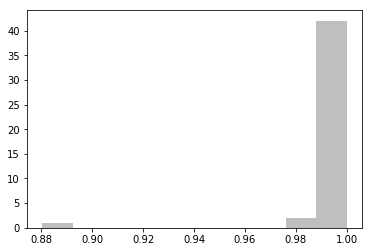

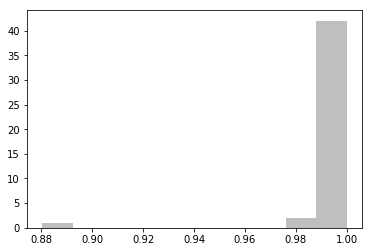

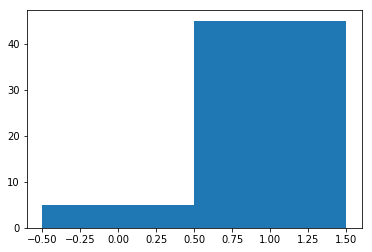

In [42]:


results, faces = detect_faces(fnames, model, args.pre_thresh)

results_noface, results_oneface, results_multiple = split_results_by_num_faces(results)

scores = [face.bbox[4] for face in faces]
scores_oneface = [result.bbox[0, 4] for result in results_oneface]
num_faces = [result.bbox.shape[0] for result in results]

results_oneface_belowthresh = [result for result in results_oneface if result.bbox[0, 4] < args.thresh]
results_oneface_valid = [result for result in results_oneface if result.bbox[0, 4] >= args.thresh]

save_histogram(scores, os.path.join(dname_result, 'scores.png'))
save_histogram(scores_oneface, os.path.join(dname_result, 'scores_oneface.png'))
save_histogram_discrete(num_faces, os.path.join(dname_result, 'num_faces.jpg'))


In [47]:
fname = 'asdf.jpg'
results = results_noface
images = []
for result in results:
    image = open_image(result.fname)
    images.append(image)
multiple_images = torch.stack(images)
save_image(multiple_images, fname)

In [56]:
import pickle
with open('results_oneface_valid.pkl', 'wb') as f:
    pickle.dump(results_oneface_valid, f)

In [57]:
with open('results_oneface_valid.pkl', 'rb') as f:
    asdf = pickle.load(f)

In [69]:
results_oneface_valid[-5:]

[Face(fname='/home/data/hairstyle/images/YXXZ6cq6FztK7IceT06hc-yM.JPG.jpg', bbox=array([[216.42229   , 174.65114   , 306.08063   , 326.26703   ,
           0.99995077]], dtype=float32), score=None),
 Face(fname='/home/data/hairstyle/images/baYBt_vUjNS_s5WpHuztMArv.JPG.jpg', bbox=array([[227.09154   , 134.6489    , 305.25977   , 289.5896    ,
           0.99993074]], dtype=float32), score=None),
 Face(fname='/home/data/hairstyle/images/t9q1Y2YmeKL3z37GGq-50pIY.jpg', bbox=array([[164.3434  ,  51.863335, 371.66016 , 277.17914 ,   1.      ]],
       dtype=float32), score=None),
 Face(fname='/home/data/hairstyle/images/olqgnWybx8b62TeyuDyxeS_D.JPG.jpg', bbox=array([[208.17273  , 111.54     , 297.64987  , 255.34229  ,   0.9999988]],
       dtype=float32), score=None),
 Face(fname='/home/data/hairstyle/images/y3gMq_TV2zOXtXusGVpgAFyP.jpg', bbox=array([[207.31705   ,  47.476784  , 391.25232   , 273.1572    ,
           0.99999917]], dtype=float32), score=None)]

In [ ]:
save_results(results_noface, os.path.join(dname_result, 'results_noface.jpg'))
save_results(results_oneface_belowthresh, os.path.join(dname_result, 'results_oneface_belowthresh.jpg'))
save_results(results_oneface_valid, os.path.join(dname_result, 'results_oneface_valid.jpg'))
save_results(results_multiple, os.path.join(dname_result, 'results_multiple.jpg'))

In [70]:
import pickle

In [71]:
fname_pkl = 'results/results.pkl'
with open(fname_pkl, 'rb') as f:
    data = pickle.load(f)

In [84]:
data[25]['fname']

'd4z8FKMpnTd_FAkGUDScLadO.jpeg.jpg'

In [ ]:
sum([[1], [2]])